In [168]:
import math

import chess
from IPython.core.display import HTML
with open('style.html', 'r') as file:
     css = file.read()
HTML(css)

In [169]:
%run Util/00_imports.ipynb
%run Util/01_functions_restructure.ipynb

In [170]:
# Global variables:

USED_BOARDS = set()
SWAPS = {
        "vertical" : {x:x^56 for x in range(64)},
        "horizontal" : {x:x^7 for x in range(64)},
        "rotate_right" : {x:(((x >> 3) | (x << 3)) & 63) ^ 56 for x in range(64)},
        "rotate_180" : {x : x ^ 63 for x in range(64)},
        "rotate_left" : {x : (((x >> 3) | (x << 3)) & 63) ^ 7 for x in range(64)},
        "diagonal" : {x : ((x >> 3) | (x << 3)) & 63 for x in range(64)},
        "anti_diagonal" : {x : (((x >> 3) | (x << 3)) & 63) ^ 63 for x in range(64)}
    }
PIECE_LIST = [chess.Piece.from_symbol("K"), chess.Piece.from_symbol("k"), chess.Piece.from_symbol("R")]
USER_WANTS_PAWN = chess.Piece.from_symbol("P") in PIECE_LIST

Definition von Enum (Fand das Stroetmann nicht unnötig? Sollten wir net einfach üüber Dict iterieren?)

In [171]:
class Swap_Type(Enum):
    VERTICAL = "vertical"
    HORIZONTAL = "horizontal"
    ROTATE_RIGHT = "rotate_right"
    ROTATE_180 = "rotate_180"
    ROTATE_LEFT = "rotate_left"
    DIAGONAL = "diagonal"
    ANTI_DIAGONAL = "anti_diagonal"

# Überlegung im Vergleich zu vorherigen Version:
* Muss der Nutzer wirklich einen Namen der Datei angeben? Können wir diesen nicht generisch erstellen?

# Voraussetzungen:
* Nutzer ist immer weiß

# Strukturüberlegung:
* Zentrale used_boards -> Müssen nicht übergeben werden
* Uniques werden gespeichert anstatt kompletter s_n Menge
* Angabe des Nutzers der aktuellen Situation
* Nutzer startet Berechnung:

# Benötigte Funktionen:

* Spiegelungen aus Uniques generieren; gen_mirroring(uniques):
    * Über Uniques iterieren
        * Über Spiegelarten iterieren
            * Spiegelung durchführen (ohne Objekterstellung in Integer-Schreibweise spiegeln)
            * Spiegelungen in Menge zusammenfassen
    * Menge zurückgeben

Menge an Schachbrettern in alle Richtungen spiegeln (falls überhaupt benötigt)

In [172]:
def gen_mirroring(uniques):
    result = set()
    for unique in uniques:
        result |= mirror_board_all(unique)
    return result

Schachbrett in alle Richtungen spiegeln

In [173]:
# Implementierung ohne ENUM:
def mirror_board_all(board_int):
    result = set()
    for name, d in SWAPS.items():
        result.add(mirror_board(board_int, d))
    return result

In [174]:
# Alternative Implementierung mit ENUM:
def mirror_board_all_enum(board_int):
    result = set()
    for sw_type in Swap_Type:
        result.add(mirror_board(board_int, SWAPS[sw_type.value]))
    return result

Mirror Board with bits in one direction

In [175]:
# Mirroring mit 6 Bit Darstellung

def mirror_board(board_int, mirror : dict):
    # Save turn
    result = board_int & 1
    # Get count of pieces saved in list -> Überlegung Liste global zu machen
    rounds = len(PIECE_LIST)
    # Remove turn
    board_int = board_int >> 1
    for index in range(rounds, 0, -1):
        result = (mirror[board_int & 63] << (6 * (index-1)) + 1) | result
        board_int = board_int >> 6
    return result

In [176]:
'''
board = chess.Board(None)
map = {20: chess.Piece.from_symbol("Q"), 5: chess.Piece.from_symbol("k") }
board.set_piece_map(map)
display(board)
int_board = to_integer(board, plist)
print(int_board)
for i in mirror_board_all(int_board):
    print(str(i) + " Spiegelung:")
    display(to_board(i, plist))
'''

'\nboard = chess.Board(None)\nmap = {20: chess.Piece.from_symbol("Q"), 5: chess.Piece.from_symbol("k") }\nboard.set_piece_map(map)\ndisplay(board)\nint_board = to_integer(board, plist)\nprint(int_board)\nfor i in mirror_board_all(int_board):\n    print(str(i) + " Spiegelung:")\n    display(to_board(i, plist))\n'

In [177]:
# TODO: Erstellen nach Lukas seiner Bitmethode, wenn ich sie komplett
# Mirroring mit 7 Bit Darstellung
def mirror_board_7(board_int, mirror : dict):
    # Save turn
    result = board_int & 1
    # Get count of pieces saved in int
    rounds = int(math.log2(board_int) // 6)
    # Remove turn
    board_int = board_int >> 1
    for index in range(rounds, 0, -1):
        result = (mirror[board_int & 127] << (7 * (index-1)) + 1) | result
        board_int = board_int >> 7
    return result

* Start der Berechnung; start_calculation():
    * Bekommt Positionen der Figuren übergeben
    * Berechnung der ersten Menge S_0, damit auch Berechnung der ersten Uniques -> Rückgabe nur Uniques
        * Hierbei erste wichtige Frage: Werden in used_boards dann ebenfalls nur die Uniques gespeichert oder auch alle?
        * Schreiben wir die ganze S_0 Menge direkt in die Datei nach der Berechnung?
    * Schleife iterieren mit altbekannter Bedingung (wenn neue Menge leer oder sich nicht unterscheidet)
        * Berechnung nächster Menge mit Übergabe der Uniques vorheriger Menge

In [178]:
def start_calculation():
    sn = calculate_s0()
    # while len(sn) != 0:
    #     sn = calculate_next_sn(sn)

* Berechnung S-0; calculate_S0():
    * Figuren überall auf dem Schachbrett positionieren und überprüfen, ob schwarz im Schach steht
    * Falls ja, dieses Brett zu uniques hinzufügen und Spiegelungen noch s_0 hinzufügen
    * 

In [179]:
def calculate_s0():
    s0 = set()
    empty_board = chess.Board(None)
    # Turn has to be black while checkmate
    empty_board.turn = chess.BLACK
    s0.add(to_integer(empty_board, PIECE_LIST))

    for piece in PIECE_LIST:
        s0 = fill_boards_with_piece(s0, piece)
        print(len(s0))
    store_sn(s0)
    return s0

In [180]:
def fill_boards_with_piece(int_boards_set, piece):
    finished_boards = set()
    all_squares = set(range(64))
    piece_count = len(PIECE_LIST)

    for int_board in int_boards_set:
        board_o = to_board(int_board, PIECE_LIST)
        used_squares = set(board_o.piece_map().keys())
        for square in all_squares:
            if square not in used_squares:
                board_object = board_o.copy()
                board_object.set_piece_at(square, piece)
                board_int = to_integer(board_object, PIECE_LIST)
                if len(used_squares) > 1 and not board_object.is_valid():
                    # Don't process invalid boards further
                    # than the second king
                    continue

                if board_object.is_checkmate():
                    if board_object.is_valid() and board_int not in USED_BOARDS:
                        finished_boards.add(board_int)
                        USED_BOARDS.add(board_int)
                        if not USER_WANTS_PAWN:
                            mirrored = mirror_board_all(board_int)
                            for i in mirrored:
                                if i not in USED_BOARDS:
                                    USED_BOARDS.add(i)
                                    finished_boards.add(i)
                        continue

                if len(used_squares) + 1 < piece_count: #Board is valid, but needs more pieces
                    finished_boards.add(board_int)
    return finished_boards

Funktion zum Platzieren der Figur auf dem Schachbrett

* Funktion zur Berechnung der nachfolgenden S-N Menge; calculate_next_sn()
    *


In [181]:
def calculate_next_sn(sn):
    sn_p_1 = set()
    for unique_board in sn:
        board_rep = to_board(unique_board)
        for move in board_rep.pseudo_legal_moves:
            pass

    store_sn(sn_p_1)
    return sn_p_1
    pass

* Funktion zur Speicherung einer S-N Menge; store_SN(uniques):
    *

In [182]:
def store_sn(sn):
    print(len(sn))
    i = 0
    for s in sn:
        display(to_board(s, PIECE_LIST))
        i += 1
        if i > 20:
            break
    pass

* Funktion zur Überprüfung der Züge von schwarz (dass diese auch bei einer Menge m landen mit m < n)
    * Einfach überprüfen, ob Züge in used_boards landen

In [183]:
def check_black_moves(uniques):
    # for int_board in uniques:
    pass

64
64
64
64


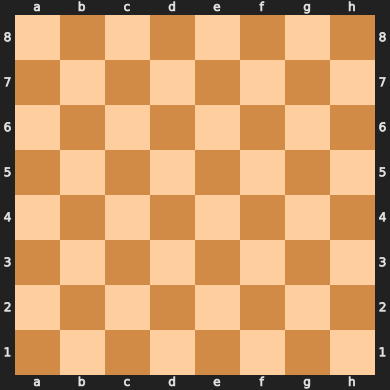

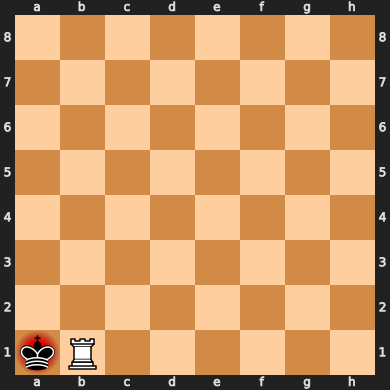

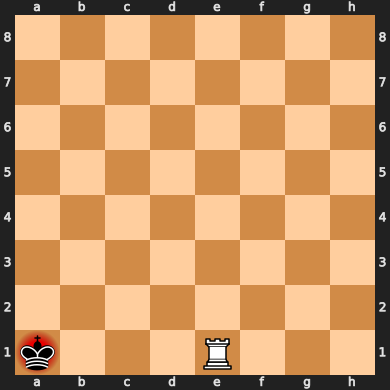

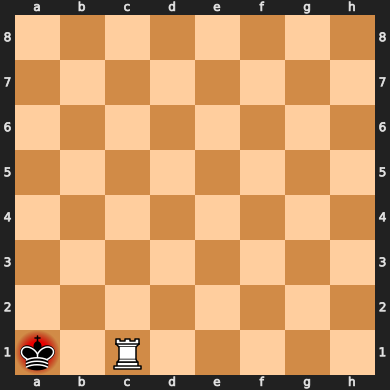

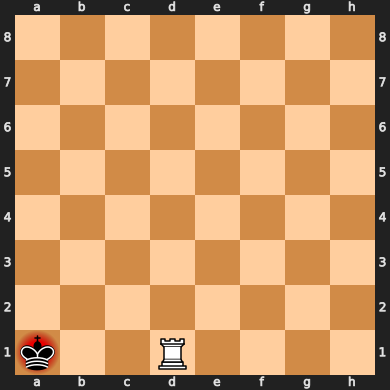

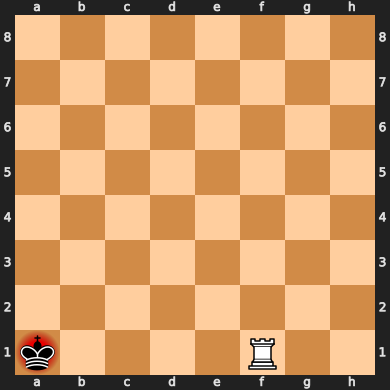

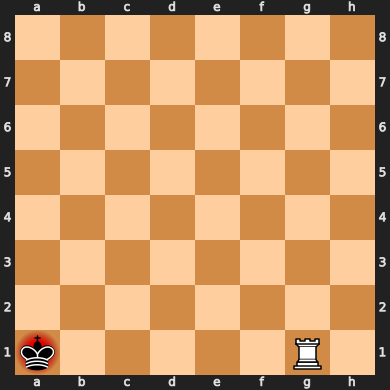

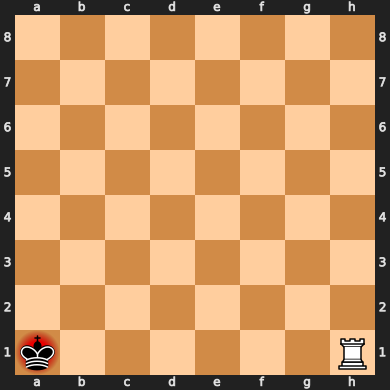

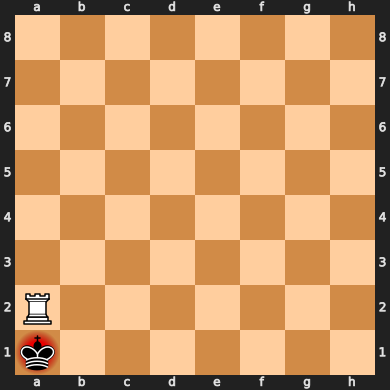

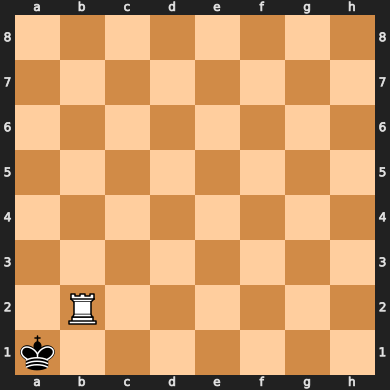

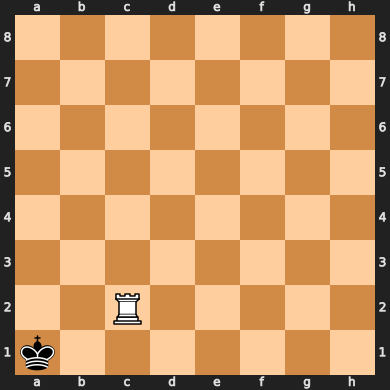

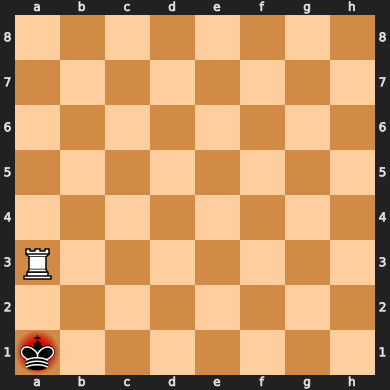

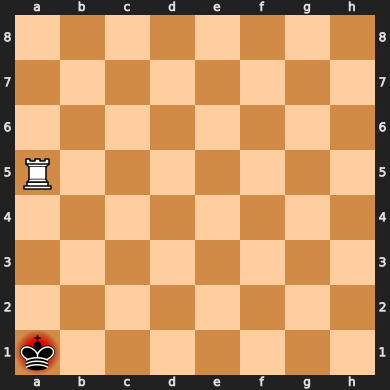

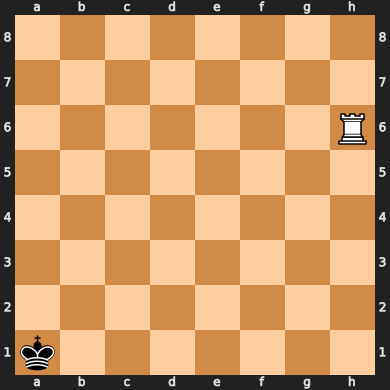

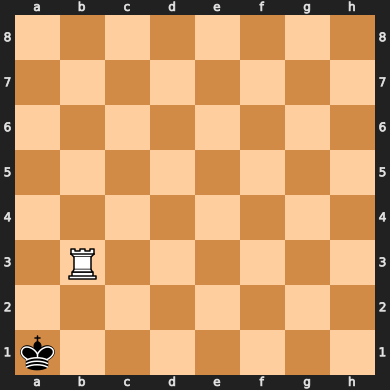

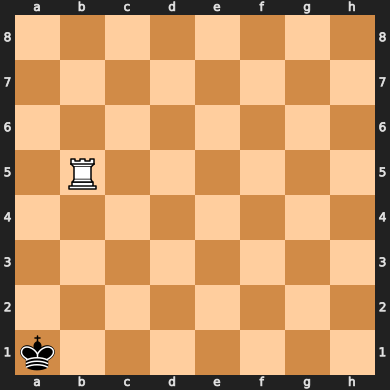

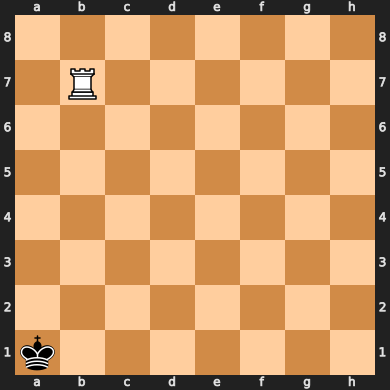

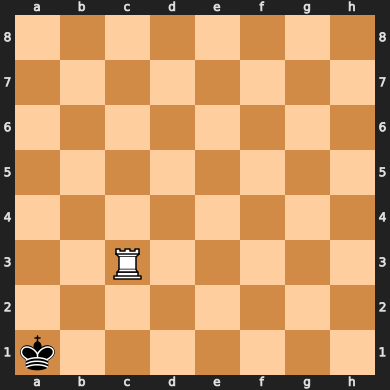

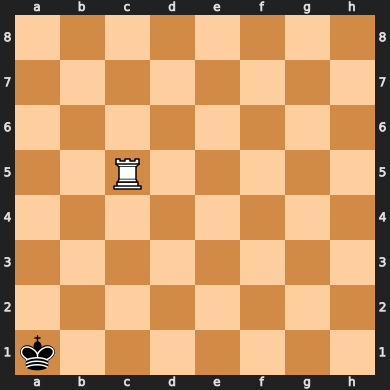

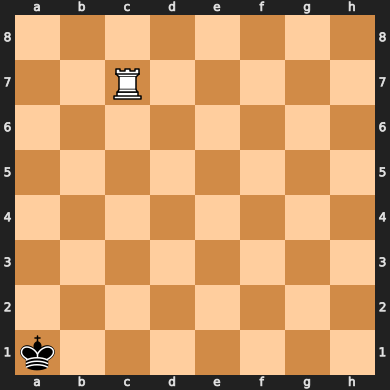

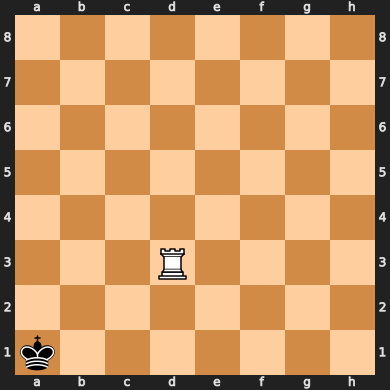

In [184]:
start_calculation()
